# Causal Simulations: stochastic TMLE
Simulated data sets demonstrating the unbiasedness of the implemented TMLE estimator for stochastic intervention plans under several different data generating mechanisms. 750 samples of 2000 individuals are used to demonstrate estimation the average causal effect of a time-fixed exposure on outcomes at a single time point for treatments including $\frac{\sum I(a=1)}{N} = \{0.00, 0.05, 0.10, ..., 0.95, 1.00\}$. All parametric models are correctly specified. Briefly described below are the main features of each data generating mechanism.

Data-generating mechanism 1:
- Binary outcome

Data-generating mechanism 2:
- Normally distributed outcome

Data-generating mechanism 3:
- Binary outcome

Confidence intervals are obtained via influence curves for the marginal parameter

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import logistic

from zepid.causal.doublyrobust import StochasticTMLE

np.random.seed(20200108)

sample_size = 2000
sim_size = 750
intervene_plans = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 
                   0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 
                   0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 
                   0.9, 0.95, 1.0]

In [2]:
def reference_value(version, plan, n=5000000):
    """Generates the reference (randomized) trial value for each potential plan
    """
    df = pd.DataFrame()
    df['A'] = np.random.binomial(n=1, p=plan, size=n)
    if version == 1:
        df['W'] = np.random.normal(10, 3, size=n)
        df['L'] = np.random.binomial(n=1, p=0.4, size=n)
        df['Y'] = np.random.binomial(n=1, p=logistic.cdf(-3*df['A'] + 0.2*df['W'] - 3*df['L']), size=n)
        return np.mean(df['Y'])
    
    if version == 2:
        df['Q'] = np.random.normal(size=n)
        df['Z'] = np.random.binomial(n=1, p=0.8, size=n)
        df['Y'] = 122 + 7*df['A'] + 0.2*df['Q'] - 0.01*df['Q']*df['Q'] + 5*df['Z'] + np.random.normal(0, 2, size=n)
        return np.mean(df['Y'])

    if version == 3:
        df['X'] = np.random.normal(size=n)
        df['B'] = np.random.binomial(n=1, p=0.6, size=n)
        df['C'] = np.random.binomial(n=1, p=0.3, size=n)
        df['Y'] = np.random.binomial(n=1, p=logistic.cdf(-5 + 3*df['A'] - 0.2*df['X'] + 3*df['B'] + 1.5*df['C'] 
                                                         + 0.1*df['X']*df['C']), size=n)
        return np.mean(df['Y'])
    
    if version == 4:
        df['S'] = np.random.normal(size=n)
        df['T'] = np.random.normal(size=n)
        df['Y'] = 27 + 1.5*df['A'] + df['S'] - 3*df['T'] + 0.6*df['A']*df['T'] + np.random.normal(size=n)
        return np.mean(df['Y'])

    
def observational_data(version, n=2000):
    """Generates one of five different data generating mechanisms for simulations.
    """
    df = pd.DataFrame()
    if version == 1:
        # Creating confounders
        df['W'] = np.random.normal(10, 3, size=n)
        df['L'] = np.random.binomial(n=1, p=0.4, size=n)
        # Treatment model
        df['A'] = np.random.binomial(n=1, p=logistic.cdf(-0.5*df['W'] + 0.02*df['W']*df['W'] + 5*df['L']), size=n)
        # Outcome model
        df['Y'] = np.random.binomial(n=1, p=logistic.cdf(-3*df['A'] + 0.2*df['W'] - 3*df['L']), size=n)
        return df
    
    if version == 2:
        # Creating confounders
        df['Q'] = np.random.normal(size=n)
        df['Z'] = np.random.binomial(n=1, p=0.8, size=n)
        # Treatment model
        df['A'] = np.random.binomial(n=1, p=logistic.cdf(0.75 + 1.5*df['Q'] - 4*df['Z']), size=n)
        # Outcome model
        df['Y'] = 122 + 7*df['A'] + 0.2*df['Q'] - 0.01*df['Q']*df['Q'] + 5*df['Z'] + np.random.normal(0, 2, size=n)
        return df

    if version == 3:
        # Creating confounders
        df['X'] = np.random.normal(size=n)
        df['B'] = np.random.binomial(n=1, p=0.6, size=n)
        df['C'] = np.random.binomial(n=1, p=0.3, size=n)
        # Treatment model
        df['A'] = np.random.binomial(n=1, p=logistic.cdf(-1.75 - 1.5*df['X'] + 3*df['B'] + 2*df['C'] 
                                                         - 5*df['B']*df['C']), size=n)
        # Outcome model
        df['Y'] = np.random.binomial(n=1, p=logistic.cdf(-5 + 3*df['A'] - 0.2*df['X'] + 3*df['B'] + 1.5*df['C'] 
                                                         + 0.1*df['X']*df['C']), size=n)
        return df
    
    if version == 4:
        # Creating confounders
        df['S'] = np.random.normal(size=n)
        # Treatment model
        df['A'] = np.random.binomial(n=1, p=logistic.cdf(-1.195 - 1.5*df['S']), size=n)
        # Outcome models
        df['Y'] = 27 + 1.5*df['A'] + 0.5*df['S'] - 0.9*df['A']*df['S'] + np.random.normal(size=n)
        return df

## Data-generating mechanism 1

In [3]:
# Simulating reference values from RCT
version = 1

reference_values = {0.0: reference_value(version, plan=0.0), 
                    0.05: reference_value(version, plan=0.05), 
                    0.1: reference_value(version, plan=0.1), 
                    0.15: reference_value(version, plan=0.15), 
                    0.2: reference_value(version, plan=0.2), 
                    0.25: reference_value(version, plan=0.25), 
                    0.3: reference_value(version, plan=0.3), 
                    0.35: reference_value(version, plan=0.35), 
                    0.4: reference_value(version, plan=0.4), 
                    0.45: reference_value(version, plan=0.45), 
                    0.5: reference_value(version, plan=0.5), 
                    0.55: reference_value(version, plan=0.55), 
                    0.6: reference_value(version, plan=0.6), 
                    0.65: reference_value(version, plan=0.65), 
                    0.7: reference_value(version, plan=0.7), 
                    0.75: reference_value(version, plan=0.75), 
                    0.8: reference_value(version, plan=0.8), 
                    0.85: reference_value(version, plan=0.85), 
                    0.9: reference_value(version, plan=0.9), 
                    0.95: reference_value(version, plan=0.95), 
                    1.0: reference_value(version, plan=1.0)}

In [4]:
# Assessment of StochasticTMLE
results = pd.DataFrame(index=range(sim_size), columns=['bias_cc_' + str(p) for p in intervene_plans] +
                       ['cover_cc_' + str(p) for p in intervene_plans] + 
                       ['bias_wc_' + str(p) for p in intervene_plans] + 
                       ['cover_wc_' + str(p) for p in intervene_plans] + 
                       ['bias_cw_' + str(p) for p in intervene_plans] + 
                       ['cover_cw_' + str(p) for p in intervene_plans] + 
                       ['bias_ww_' + str(p) for p in intervene_plans] + 
                       ['cover_ww_' + str(p) for p in intervene_plans])

for i in range(sim_size):
    df = observational_data(version=1, n=sample_size)
    df['W_sq'] = df['W']**2
    
    # Q-model and g-model correctly specified
    tmle = StochasticTMLE(df, exposure='A', outcome='Y', verbose=False)
    tmle.exposure_model('W + W_sq + L')
    tmle.outcome_model('A + W + L')
    for j in intervene_plans:
        tmle.fit(p=j)
        results.loc[i, 'bias_cc_'+str(j)] = tmle.marginal_outcome - reference_values[j]
        if tmle.marginal_ci[0] < reference_values[j] < tmle.marginal_ci[1]:
            results.loc[i, 'cover_cc_' + str(j)] = 1
        else:
            results.loc[i, 'cover_cc_' + str(j)] = 0

    # Q-model incorrectly specified
    tmle = StochasticTMLE(df, exposure='A', outcome='Y', verbose=False)
    tmle.exposure_model('W + W_sq + L')
    tmle.outcome_model('A')
    for j in intervene_plans:
        tmle.fit(p=j)
        results.loc[i, 'bias_cw_'+str(j)] = tmle.marginal_outcome - reference_values[j]
        if tmle.marginal_ci[0] < reference_values[j] < tmle.marginal_ci[1]:
            results.loc[i, 'cover_cw_' + str(j)] = 1
        else:
            results.loc[i, 'cover_cw_' + str(j)] = 0

    # g-model incorrectly specified
    tmle = StochasticTMLE(df, exposure='A', outcome='Y', verbose=False)
    tmle.exposure_model('L')
    tmle.outcome_model('A + W + L')
    for j in intervene_plans:
        tmle.fit(p=j)
        results.loc[i, 'bias_wc_'+str(j)] = tmle.marginal_outcome - reference_values[j]
        if tmle.marginal_ci[0] < reference_values[j] < tmle.marginal_ci[1]:
            results.loc[i, 'cover_wc_' + str(j)] = 1
        else:
            results.loc[i, 'cover_wc_' + str(j)] = 0

    # Q-model and g-model incorrectly specified
    tmle = StochasticTMLE(df, exposure='A', outcome='Y', verbose=False)
    tmle.exposure_model('L')
    tmle.outcome_model('A')
    for j in intervene_plans:
        tmle.fit(p=j)
        results.loc[i, 'bias_ww_'+str(j)] = tmle.marginal_outcome - reference_values[j]
        if tmle.marginal_ci[0] < reference_values[j] < tmle.marginal_ci[1]:
            results.loc[i, 'cover_ww_' + str(j)] = 1
        else:
            results.loc[i, 'cover_ww_' + str(j)] = 0


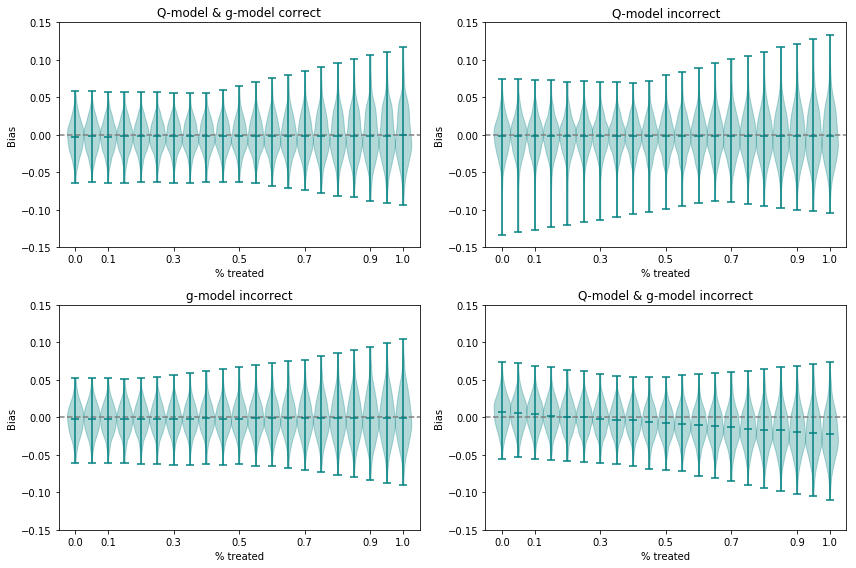

In [5]:
# Plotting results
plt.figure(figsize=[12, 8])

# Bias results
plt.subplot(221)
plt.hlines([0], [-0.05], [1.05], colors='gray', linestyles='--')
dat = [list(np.array(results['bias_cc_'+str(i)])) for i in intervene_plans]
parts = plt.violinplot(dat, positions=intervene_plans,
                      showmeans=True, showmedians=False, widths=0.05)
for pc in parts['bodies']:
    pc.set_color('teal')

for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = parts[partname]
    vp.set_edgecolor('teal')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.15, 0.15])
plt.xticks([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0])
plt.xlabel("% treated")
plt.ylabel("Bias")
plt.title("Q-model & g-model correct")

plt.subplot(222)
plt.hlines([0], [-0.05], [1.05], colors='gray', linestyles='--')
dat = [list(np.array(results['bias_cw_'+str(i)])) for i in intervene_plans]
parts = plt.violinplot(dat, positions=intervene_plans,
                      showmeans=True, showmedians=False, widths=0.05)
for pc in parts['bodies']:
    pc.set_color('teal')

for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = parts[partname]
    vp.set_edgecolor('teal')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.15, 0.15])
plt.xticks([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0])
plt.xlabel("% treated")
plt.ylabel("Bias")
plt.title("Q-model incorrect")

plt.subplot(223)
plt.hlines([0], [-0.05], [1.05], colors='gray', linestyles='--')
dat = [list(np.array(results['bias_wc_'+str(i)])) for i in intervene_plans]
parts = plt.violinplot(dat, positions=intervene_plans,
                      showmeans=True, showmedians=False, widths=0.05)
for pc in parts['bodies']:
    pc.set_color('teal')

for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = parts[partname]
    vp.set_edgecolor('teal')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.15, 0.15])
plt.xticks([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0])
plt.xlabel("% treated")
plt.ylabel("Bias")
plt.title("g-model incorrect")

plt.subplot(224)
plt.hlines([0], [-0.05], [1.05], colors='gray', linestyles='--')
dat = [list(np.array(results['bias_ww_'+str(i)])) for i in intervene_plans]
parts = plt.violinplot(dat, positions=intervene_plans,
                      showmeans=True, showmedians=False, widths=0.05)
for pc in parts['bodies']:
    pc.set_color('teal')

for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = parts[partname]
    vp.set_edgecolor('teal')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.15, 0.15])
plt.xticks([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0])
plt.xlabel("% treated")
plt.ylabel("Bias")
plt.title("Q-model & g-model incorrect")

plt.tight_layout()
plt.show()

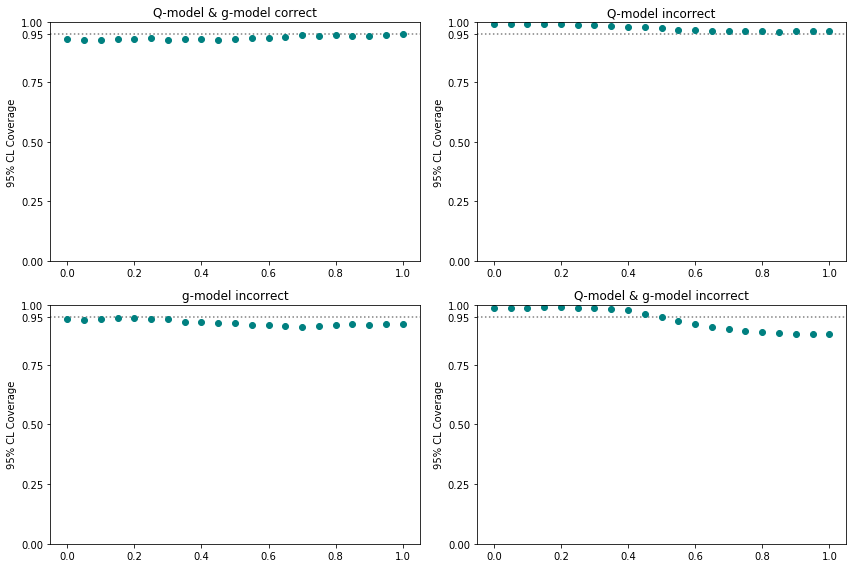

In [6]:
plt.figure(figsize=[12, 8])

# Confidence interval coverage
plt.subplot(221)
plt.hlines(0.95, -0.05, 1.05, linestyles=':', color='gray')
dat = [np.mean(results[i]) for i in ['cover_cc_'+str(i) for i in intervene_plans]]
plt.plot(intervene_plans, dat, 'o', color='teal')
plt.ylabel('95% CL Coverage')
plt.ylim([0, 1])
plt.xlim([-0.05, 1.05])
plt.yticks([0, 0.25, 0.5, 0.75, 0.95, 1.0])
plt.title("Q-model & g-model correct")

plt.subplot(222)
plt.hlines(0.95, -0.05, 1.05, linestyles=':', color='gray')
dat = [np.mean(results[i]) for i in ['cover_cw_'+str(i) for i in intervene_plans]]
plt.plot(intervene_plans, dat, 'o', color='teal')
plt.ylabel('95% CL Coverage')
plt.ylim([0, 1])
plt.xlim([-0.05, 1.05])
plt.yticks([0, 0.25, 0.5, 0.75, 0.95, 1.0])
plt.title("Q-model incorrect")

plt.subplot(223)
plt.hlines(0.95, -0.05, 1.05, linestyles=':', color='gray')
dat = [np.mean(results[i]) for i in ['cover_wc_'+str(i) for i in intervene_plans]]
plt.plot(intervene_plans, dat, 'o', color='teal')
plt.ylabel('95% CL Coverage')
plt.ylim([0, 1])
plt.xlim([-0.05, 1.05])
plt.yticks([0, 0.25, 0.5, 0.75, 0.95, 1.0])
plt.title("g-model incorrect")

plt.subplot(224)
plt.hlines(0.95, -0.05, 1.05, linestyles=':', color='gray')
dat = [np.mean(results[i]) for i in ['cover_ww_'+str(i) for i in intervene_plans]]
plt.plot(intervene_plans, dat, 'o', color='teal')
plt.ylabel('95% CL Coverage')
plt.ylim([0, 1])
plt.xlim([-0.05, 1.05])
plt.yticks([0, 0.25, 0.5, 0.75, 0.95, 1.0])
plt.title("Q-model & g-model incorrect")

plt.tight_layout()
plt.show()

## Data-generating mechanism 2

In [7]:
# Simulating reference values from RCT
version = 2

reference_values = {0.0: reference_value(version, plan=0.0), 
                    0.05: reference_value(version, plan=0.05), 
                    0.1: reference_value(version, plan=0.1), 
                    0.15: reference_value(version, plan=0.15), 
                    0.2: reference_value(version, plan=0.2), 
                    0.25: reference_value(version, plan=0.25), 
                    0.3: reference_value(version, plan=0.3), 
                    0.35: reference_value(version, plan=0.35), 
                    0.4: reference_value(version, plan=0.4), 
                    0.45: reference_value(version, plan=0.45), 
                    0.5: reference_value(version, plan=0.5), 
                    0.55: reference_value(version, plan=0.55), 
                    0.6: reference_value(version, plan=0.6), 
                    0.65: reference_value(version, plan=0.65), 
                    0.7: reference_value(version, plan=0.7), 
                    0.75: reference_value(version, plan=0.75), 
                    0.8: reference_value(version, plan=0.8), 
                    0.85: reference_value(version, plan=0.85), 
                    0.9: reference_value(version, plan=0.9), 
                    0.95: reference_value(version, plan=0.95), 
                    1.0: reference_value(version, plan=1.0)}

In [8]:
# Assessment of StochasticTMLE
results = pd.DataFrame(index=range(sim_size), columns=['bias_cc_' + str(p) for p in intervene_plans] +
                       ['cover_cc_' + str(p) for p in intervene_plans] + 
                       ['bias_wc_' + str(p) for p in intervene_plans] + 
                       ['cover_wc_' + str(p) for p in intervene_plans] + 
                       ['bias_cw_' + str(p) for p in intervene_plans] + 
                       ['cover_cw_' + str(p) for p in intervene_plans] + 
                       ['bias_ww_' + str(p) for p in intervene_plans] + 
                       ['cover_ww_' + str(p) for p in intervene_plans])

for i in range(sim_size):
    df = observational_data(version=2, n=sample_size)
    df['Q_sq'] = df['Q']**2
    
    tmle = StochasticTMLE(df, exposure='A', outcome='Y', verbose=False)
    tmle.exposure_model('Q + Z')
    tmle.outcome_model('A + Q + Q_sq + Z')
    for j in intervene_plans:
        tmle.fit(p=j)
        results.loc[i, 'bias_cc_'+str(j)] = tmle.marginal_outcome - reference_values[j]
        if tmle.marginal_ci[0] < reference_values[j] < tmle.marginal_ci[1]:
            results.loc[i, 'cover_cc_' + str(j)] = 1
        else:
            results.loc[i, 'cover_cc_' + str(j)] = 0

    tmle = StochasticTMLE(df, exposure='A', outcome='Y', verbose=False)
    tmle.exposure_model('Q + Z')
    tmle.outcome_model('A + Z')
    for j in intervene_plans:
        tmle.fit(p=j)
        results.loc[i, 'bias_cw_'+str(j)] = tmle.marginal_outcome - reference_values[j]
        if tmle.marginal_ci[0] < reference_values[j] < tmle.marginal_ci[1]:
            results.loc[i, 'cover_cw_' + str(j)] = 1
        else:
            results.loc[i, 'cover_cw_' + str(j)] = 0

    tmle = StochasticTMLE(df, exposure='A', outcome='Y', verbose=False)
    tmle.exposure_model('Z')
    tmle.outcome_model('A + Q + Q_sq + Z')
    for j in intervene_plans:
        tmle.fit(p=j)
        results.loc[i, 'bias_wc_'+str(j)] = tmle.marginal_outcome - reference_values[j]
        if tmle.marginal_ci[0] < reference_values[j] < tmle.marginal_ci[1]:
            results.loc[i, 'cover_wc_' + str(j)] = 1
        else:
            results.loc[i, 'cover_wc_' + str(j)] = 0

    tmle = StochasticTMLE(df, exposure='A', outcome='Y', verbose=False)
    tmle.exposure_model('Z')
    tmle.outcome_model('A + Z')
    for j in intervene_plans:
        tmle.fit(p=j)
        results.loc[i, 'bias_ww_'+str(j)] = tmle.marginal_outcome - reference_values[j]
        if tmle.marginal_ci[0] < reference_values[j] < tmle.marginal_ci[1]:
            results.loc[i, 'cover_ww_' + str(j)] = 1
        else:
            results.loc[i, 'cover_ww_' + str(j)] = 0


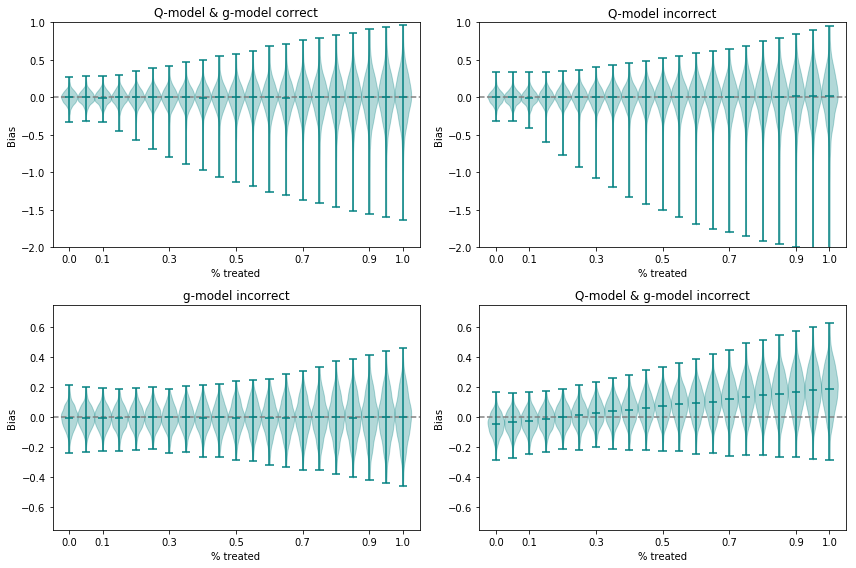

In [14]:
# Plotting results
plt.figure(figsize=[12, 8])

# Bias results
plt.subplot(221)
plt.hlines([0], [-0.05], [1.05], colors='gray', linestyles='--')
dat = [list(np.array(results['bias_cc_'+str(i)])) for i in intervene_plans]
parts = plt.violinplot(dat, positions=intervene_plans,
                      showmeans=True, showmedians=False, widths=0.05)
for pc in parts['bodies']:
    pc.set_color('teal')

for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = parts[partname]
    vp.set_edgecolor('teal')

plt.xlim([-0.05, 1.05])
plt.ylim([-2., 1.])
plt.xticks([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0])
plt.xlabel("% treated")
plt.ylabel("Bias")
plt.title("Q-model & g-model correct")

plt.subplot(222)
plt.hlines([0], [-0.05], [1.05], colors='gray', linestyles='--')
dat = [list(np.array(results['bias_cw_'+str(i)])) for i in intervene_plans]
parts = plt.violinplot(dat, positions=intervene_plans,
                      showmeans=True, showmedians=False, widths=0.05)
for pc in parts['bodies']:
    pc.set_color('teal')

for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = parts[partname]
    vp.set_edgecolor('teal')

plt.xlim([-0.05, 1.05])
plt.ylim([-2., 1.])
plt.xticks([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0])
plt.xlabel("% treated")
plt.ylabel("Bias")
plt.title("Q-model incorrect")

plt.subplot(223)
plt.hlines([0], [-0.05], [1.05], colors='gray', linestyles='--')
dat = [list(np.array(results['bias_wc_'+str(i)])) for i in intervene_plans]
parts = plt.violinplot(dat, positions=intervene_plans,
                      showmeans=True, showmedians=False, widths=0.05)
for pc in parts['bodies']:
    pc.set_color('teal')

for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = parts[partname]
    vp.set_edgecolor('teal')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.75, 0.75])
plt.xticks([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0])
plt.xlabel("% treated")
plt.ylabel("Bias")
plt.title("g-model incorrect")

plt.subplot(224)
plt.hlines([0], [-0.05], [1.05], colors='gray', linestyles='--')
dat = [list(np.array(results['bias_ww_'+str(i)])) for i in intervene_plans]
parts = plt.violinplot(dat, positions=intervene_plans,
                      showmeans=True, showmedians=False, widths=0.05)
for pc in parts['bodies']:
    pc.set_color('teal')

for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = parts[partname]
    vp.set_edgecolor('teal')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.75, 0.75])
plt.xticks([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0])
plt.xlabel("% treated")
plt.ylabel("Bias")
plt.title("Q-model & g-model incorrect")

plt.tight_layout()
plt.show()

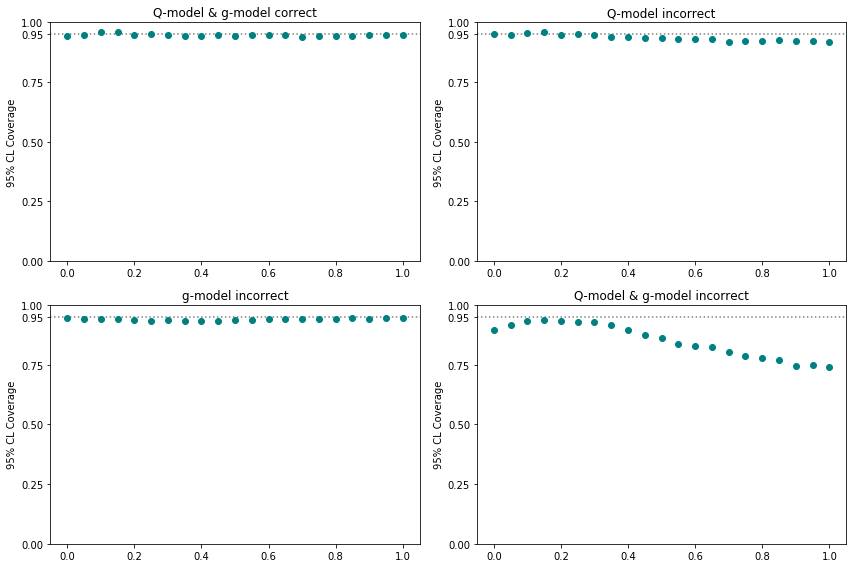

In [10]:
plt.figure(figsize=[12, 8])

# Confidence interval coverage
plt.subplot(221)
plt.hlines(0.95, -0.05, 1.05, linestyles=':', color='gray')
dat = [np.mean(results[i]) for i in ['cover_cc_'+str(i) for i in intervene_plans]]
plt.plot(intervene_plans, dat, 'o', color='teal')
plt.ylabel('95% CL Coverage')
plt.ylim([0, 1])
plt.xlim([-0.05, 1.05])
plt.yticks([0, 0.25, 0.5, 0.75, 0.95, 1.0])
plt.title("Q-model & g-model correct")

plt.subplot(222)
plt.hlines(0.95, -0.05, 1.05, linestyles=':', color='gray')
dat = [np.mean(results[i]) for i in ['cover_cw_'+str(i) for i in intervene_plans]]
plt.plot(intervene_plans, dat, 'o', color='teal')
plt.ylabel('95% CL Coverage')
plt.ylim([0, 1])
plt.xlim([-0.05, 1.05])
plt.yticks([0, 0.25, 0.5, 0.75, 0.95, 1.0])
plt.title("Q-model incorrect")

plt.subplot(223)
plt.hlines(0.95, -0.05, 1.05, linestyles=':', color='gray')
dat = [np.mean(results[i]) for i in ['cover_wc_'+str(i) for i in intervene_plans]]
plt.plot(intervene_plans, dat, 'o', color='teal')
plt.ylabel('95% CL Coverage')
plt.ylim([0, 1])
plt.xlim([-0.05, 1.05])
plt.yticks([0, 0.25, 0.5, 0.75, 0.95, 1.0])
plt.title("g-model incorrect")

plt.subplot(224)
plt.hlines(0.95, -0.05, 1.05, linestyles=':', color='gray')
dat = [np.mean(results[i]) for i in ['cover_ww_'+str(i) for i in intervene_plans]]
plt.plot(intervene_plans, dat, 'o', color='teal')
plt.ylabel('95% CL Coverage')
plt.ylim([0, 1])
plt.xlim([-0.05, 1.05])
plt.yticks([0, 0.25, 0.5, 0.75, 0.95, 1.0])
plt.title("Q-model & g-model incorrect")

plt.tight_layout()
plt.show()

Data generating mechanism not presented due to long run-time to assess double-robustness feature for the previous simulations